In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout
import matplotlib.pyplot as plt
from IPython.display import clear_output

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, window_size=5):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}
        self.window_size = window_size  # Moving average window size

    def moving_average(self, data, window_size):
        """Compute a moving average of the input data."""
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def on_epoch_end(self, epoch, logs=None):
        # Append the current epoch's logs
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['precision'].append(logs.get('precision'))
        self.history['val_precision'].append(logs.get('val_precision'))
        self.history['recall'].append(logs.get('recall'))
        self.history['val_recall'].append(logs.get('val_recall'))

        # Clear previous output to update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(15, 10))

        # Plot Loss with moving average
        plt.subplot(2, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Accuracy with moving average
        plt.subplot(2, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Tighten layout and show plot
        plt.tight_layout()
        plt.show()

##############################################################################
# 1) Load and prepare data
##############################################################################
def load_and_prepare_data():
    files = [
        'Classification music/GenreClassData_5s.txt', 
        'Classification music/GenreClassData_10s.txt', 
        'Classification music/GenreClassData_30s.txt'
    ]
    
    train_data_list = []
    test_data_list = []
    datasets = []
    
    # -- Read files and split train/test
    for file in files:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()  # Remove whitespace from column names
        
        test_df = df[df["Type"] == "Test"]
        train_df = df[df["Type"] == "Train"]
        
        train_labels = train_df["GenreID"].values
        test_labels  = test_df["GenreID"].values
        
        # Drop unnecessary columns
        train_df = train_df.drop(columns=["File", "Genre", "GenreID", "Type"])
        test_df  = test_df.drop(columns=["File", "Genre", "GenreID", "Type"])
        
        # Store the arrays
        train_data_list.append(train_df.values)
        test_data_list.append(test_df.values)
    
    # -- For each of (train_data_list, test_data_list),
    #    we combine the 5s, 10s, and 30s sets with the right repetition.
    for data_list in [train_data_list, test_data_list]:
        data_5s, data_10s, data_30s = data_list
        
        # Repeat to match sequence length
        data_10s_repeated = np.repeat(data_10s, 2, axis=0)
        data_30s_repeated = np.repeat(data_30s, 6, axis=0)
        
        # Concatenate along the feature dimension
        combined_data = np.concatenate((data_5s, data_10s_repeated, data_30s_repeated), axis=1)
        
        # Remove the Track ID columns (positions 0, 63, 126 if they exist)
        combined_data = np.delete(combined_data, [0, 63, 126], axis=1)
        
        # The first pass is for train data, second for test data
        if len(datasets) == 0:
            datasets.append([combined_data, train_labels])
        else:
            datasets.append([combined_data, test_labels])
    
    # datasets[0] = train, datasets[1] = test
    return datasets[0], datasets[1]

##############################################################################
# 2) Load the data
##############################################################################
train, test = load_and_prepare_data()
train_ds, train_labels = train  # train_ds shape => (6*N, num_features)
test_ds,  test_labels  = test   # test_ds shape  => (6*M, num_features)

print("Raw train_ds shape:", train_ds.shape)
print("Raw train_labels shape:", train_labels.shape)
print("Raw test_ds shape:", test_ds.shape)
print("Raw test_labels shape:", test_labels.shape)

##############################################################################
# 3) Reshape data so each group of 6 rows is a single sequence
##############################################################################
N_train = train_labels.shape[0]
N_test  = test_labels.shape[0]

# Check if train_ds has exactly 6*N_train rows
assert train_ds.shape[0] == 6 * N_train, (
    f"train_ds has {train_ds.shape[0]} rows, but we expected {6 * N_train}"
)

# Similarly for test
assert test_ds.shape[0] == 6 * N_test, (
    f"test_ds has {test_ds.shape[0]} rows, but we expected {6 * N_test}"
)

# Number of features (columns) in the flat data
num_features = train_ds.shape[1]

# Reshape to (N, 6, num_features)
train_ds = train_ds.reshape((N_train, 6, num_features))
test_ds  = test_ds.reshape((N_test, 6, num_features))

print("Reshaped train_ds shape:", train_ds.shape)
print("Reshaped test_ds shape:", test_ds.shape)

##############################################################################
# 4) Build tf.data Datasets
##############################################################################
batch_size = 32
global_mean = tf.reduce_mean(train_ds, axis=(0, 1))
global_std = tf.math.reduce_std(train_ds, axis=(0, 1))

tf_train_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
# Normalize the dataset
def normalize_data(x, y):
    x = tf.cast(x, tf.float64)  # Ensure the feature tensor remains float64
    x = (x - global_mean) / global_std
    y = tf.cast(y, tf.int64)  # Ensure the label tensor remains int64
    return x, y

tf_train_ds = (
    tf_train_ds
    .map(normalize_data)
    .shuffle(buffer_size=700)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Calculate and save the global mean and standard deviation


tf_test_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
# Create a validation split of 10% from the shuffled train_ds
# val_size = int(0.1 * len(tf_train_ds))
# val_ds = tf_train_ds.take(val_size)
# tf_train_ds = tf_train_ds.skip(val_size)

# Prepare the test dataset
tf_test_ds = (
    tf_test_ds
    .map(normalize_data)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

##############################################################################
# 5) Build and compile the model
##############################################################################
model = Sequential()

# LSTM expects input_shape=(sequence_length, feature_dim), here (6, num_features)
model.add(LSTM(16, return_sequences=True, dropout=0.3, input_shape=(6, num_features)))
model.add(BatchNormalization())
model.add(LSTM(16, return_sequences=False, dropout=0.3))
model.add(BatchNormalization())
for _ in range(2):
    model.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

for i in range(2):
    dim = int(16 / (2**i))
    model.add(Dense(dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


num_classes = len(np.unique(train_labels))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

ImportError: Traceback (most recent call last):
  File "c:\Users\vetle\Documents\GitHub\TTT4275-Music-genre-classification\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [99]:
for x, y in tf_train_ds.take(1):
    print("x shape:", x.shape)
    print("y shape:", y.shape)
    print(x.numpy()[0][0])
    break

x shape: (32, 6, 189)
y shape: (32,)
[-0.74634976 -0.2331768   0.30379402 -0.23453651 -0.57169311 -0.11804357
 -0.40268318  0.22558604 -0.45205961  0.14585543  0.89906605  1.27186031
 -0.6799638  -0.71909285 -0.63072479 -0.40056433 -0.1054193   0.07676566
  0.66328138  0.47219267  1.59361358 -0.50625451 -0.33430786  0.18107721
 -0.4238383   0.45711559 -0.5277455  -0.1790763   0.69899466 -0.12482108
  1.27149124  0.16812402  1.44001815 -0.59243231 -0.36734108  0.61956963
 -0.22920065  0.6249131  -1.81255357  0.2885637   0.62683941 -0.26018283
  0.54370238 -0.42824427  0.52506175 -1.58542564  1.06985633 -0.55871689
  1.68482012  0.08677507  0.27814186 -0.05029392  0.24979802 -0.13879576
  0.26360003  0.35573483  0.83515309 -1.06326861  0.01802696 -1.21424129
 -0.97956146 -0.77422354 -0.34089472 -0.80401582 -0.59198434  0.24421097
 -0.29962607 -0.62817021 -0.5223757  -0.42871002 -0.11395402 -0.50276341
 -0.14667853  0.9603485   1.2589151  -0.69843832 -0.76258861 -0.61696326
 -0.47156265 -

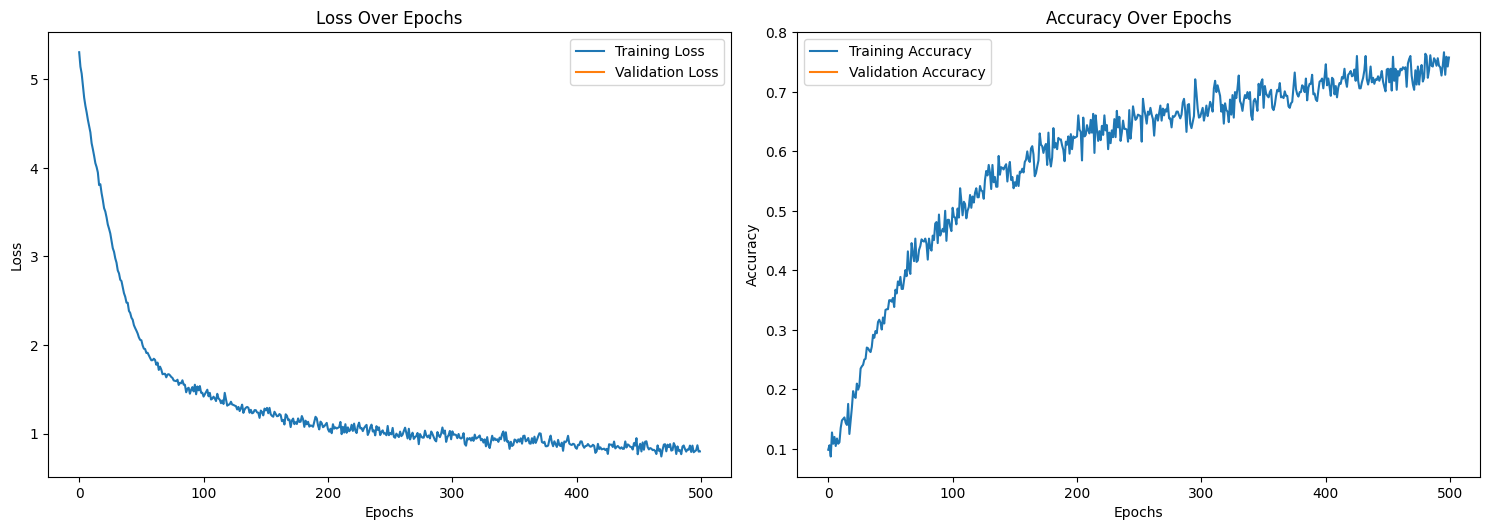

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7706 - loss: 0.7499 - learning_rate: 0.0010
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8648 - loss: 0.7416  


[0.7776668667793274, 0.8636363744735718]

In [92]:
##############################################################################
# 6) Train and evaluate

model.fit(tf_train_ds, epochs=500, verbose=1, callbacks=[LivePlotCallback(window_size=5), tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-6), tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')]) # validation_data=val_ds,
model.evaluate(tf_test_ds, verbose=1)

In [ ]:
model.fit(tf_train_ds, epochs=500, verbose=1, callbacks=[LivePlotCallback(window_size=5), tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-6), tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')]) # validation_data=val_ds,
model.evaluate(tf_test_ds, verbose=1)

Epoch 1/500


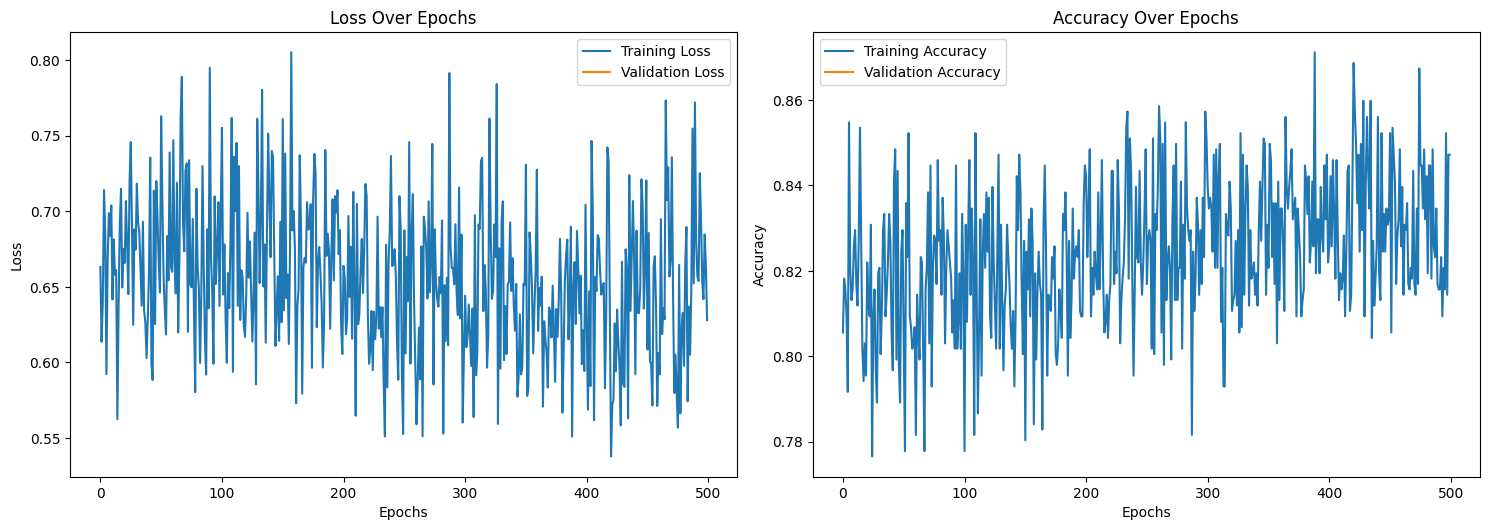

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8301 - loss: 0.6735 - learning_rate: 0.0010
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8417 - loss: 0.9333 


[0.8925228118896484, 0.8434343338012695]

In [98]:
model.fit(tf_train_ds, epochs=500, verbose=1, callbacks=[LivePlotCallback(window_size=5), tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-6), tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')]) # validation_data=val_ds,
model.evaluate(tf_test_ds, verbose=1)

In [100]:
model.save('models/v7model.keras')

In [5]:
# Load the best model
best_model = tf.keras.models.load_model('models/model_val100_test_85.h5')
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(tf_test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
model.summary()

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.8551 - loss: 1.3611
Test Loss: 1.4346
Test Accuracy: 0.8434


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 16)          │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,690 (65.20 KB)

 Trainable params: 16,514 (64.51 KB)

 Non-trainable params: 176 (704.00 B)